In [42]:
import pandas as pd
import networkx as nx
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

In [43]:
data = pd.read_excel("datatouse.xlsx")
data.head()

,subject,relation,object
0,acute_copd_exacerbation_infection,has_symptomatology,"Worsening shortness of breath, chronic cough w..."
1,acute_copd_exacerbation_infection,has_symptomatology,Increased sputum purulence and volume
2,acute_copd_exacerbation_infection,has_lifestyle,Common in smokers or individuals exposed to po...
3,acute_copd_exacerbation_infection,has_anamnesis,History of chronic obstructive pulmonary disea...
4,acute_copd_exacerbation_infection,has_therapy,Bronchodilators and antibiotics if bacterial i...


In [44]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [45]:
def encode_text(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state.mean(dim=1).numpy()

In [46]:
embeddings = encode_text(data['object'].tolist())


In [75]:
# Agglomerative Clustering (Hierarchical Clustering)
num_clusters = 8  # Number of disease clusters (adjust based on expected clusters)
agg_clust = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward') 
data['cluster'] = agg_clust.fit_predict(embeddings)

In [76]:
def hierarchical_aggregation(cluster_id):
    if cluster_id in [0, 1]:
        return 'Respiratory Diseases'
    else:
        return 'Cardiovascular Diseases'

data['higher_level_category'] = data['cluster'].apply(hierarchical_aggregation)

In [77]:
G = nx.Graph()

# Add nodes for each disease
for idx, row in data.iterrows():
    G.add_node(row['subject'], cluster=row['cluster'], description=row['object'])


In [78]:
for cluster_id in range(num_clusters):
    cluster_nodes = data[data['cluster'] == cluster_id]['subject'].tolist()
    for i in range(len(cluster_nodes)):
        for j in range(i + 1, len(cluster_nodes)):
            # Add an edge between nodes that belong to the same cluster
            G.add_edge(cluster_nodes[i], cluster_nodes[j])

In [79]:
node_colors = [data.loc[data['subject'] == node, 'cluster'].values[0] for node in G.nodes]

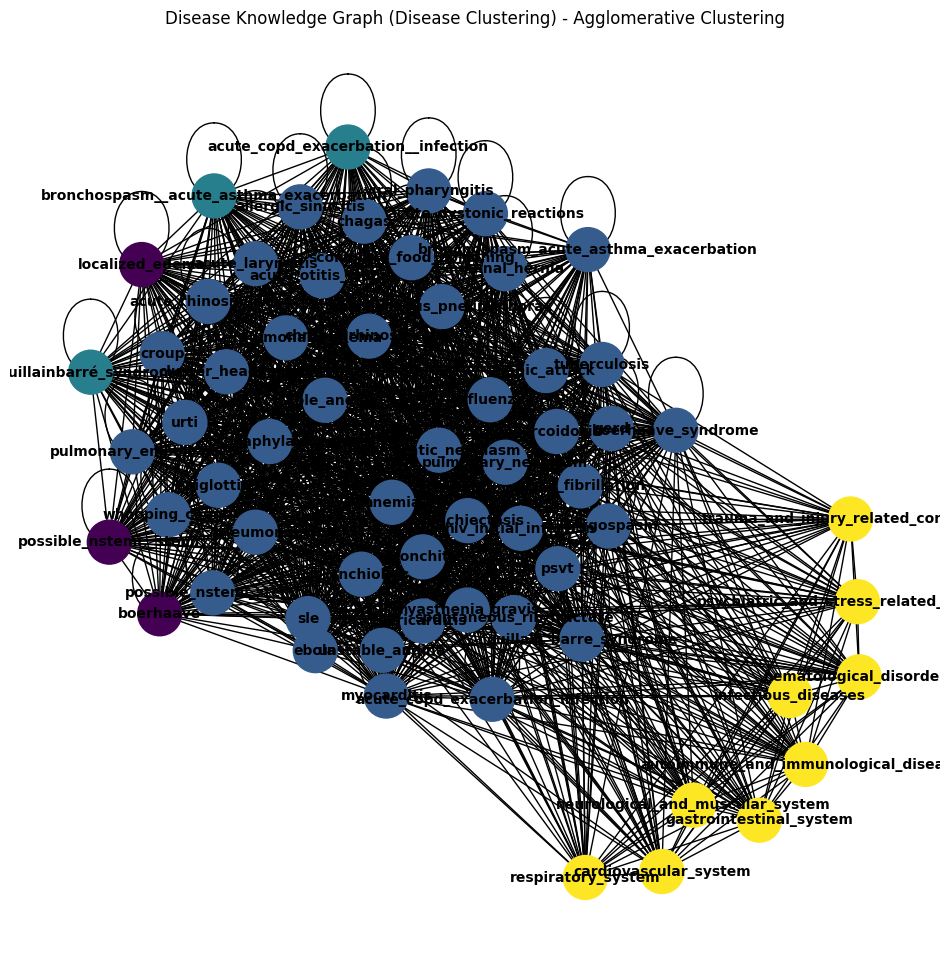

In [80]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=55)
plt.title("Disease Knowledge Graph (Disease Clustering) - Agglomerative Clustering")

# Draw the graph with different colors based on clusters
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, cmap=plt.cm.viridis, font_size=10, font_weight='bold')

# Show the plot
plt.show()

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity between embeddings and cluster centroids
centroids = np.array([embeddings[data['cluster'] == i].mean(axis=0) for i in range(num_clusters)])
similarities = cosine_similarity(embeddings, centroids)

# Find the top terms for each cluster
top_terms = {}
for cluster_id in range(num_clusters):
    cluster_indices = np.where(data['cluster'] == cluster_id)[0]
    cluster_similarities = similarities[cluster_indices, cluster_id]
    top_indices = cluster_indices[np.argsort(cluster_similarities)[-3:]]  # Top 3 indices
    top_terms[cluster_id] = [tokenizer.convert_ids_to_tokens(torch.argmax(embeddings[idx]).item()) for idx in top_indices]

print("Top terms for each cluster (simulated topics):")
for cluster_id, terms in top_terms.items():
    print(f"Cluster {cluster_id}: {', '.join(terms)}")

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not numpy.ndarray